## Step 1: Problem and Data Description

### Problem Statement
In this project, we aim to build unsupervised learning models to detect potentially fraudulent credit card transactions. This is an anomaly detection problem, where fraudulent samples are rare (less than 1% of the total) and not used for model training. Instead, we use unsupervised methods that learn the structure of normal transactions and flag any deviations as potential fraud.

We will explore two modeling approaches:

- **Isolation Forest: A tree-based model that isolates anomalies through random splits.**

- **Autoencoder: A neural network trained to reconstruct input data, where large reconstruction errors may indicate anomalies.**

Each model will be evaluated against the known fraud labels using metrics such as ROC-AUC and precision-recall to determine how well it identifies fraud. Through this project, we aim to develop a solid understanding of anomaly detection, high-dimensional EDA, and how unsupervised learning can be applied in real-world financial security applications.

This problem is based on the IEEE-CIS Fraud Detection competition on Kaggle.

---

### Input Overview

The following files are provided:

- `train_transaction.csv` — contains transaction data including anonymized engineered features and fraud labels.

- `train_identity.csv` — contains identity-related features for some of the transactions.

- `test_transaction.csv` — transaction data for test cases (no fraud labels).

- `test_identity.csv` - identity-related features for test cases.

- `sample_submission.csv` — template for submitting predictions on the test set.

---


### Input Format

Each row in the transaction dataset corresponds to a unique online purchase. The dataset includes:

- Anonymized numerical features (V1 to V339)

- Explicit features like:

  - `TransactionDT`: Time of transaction
  - `TransactionAmt`: Amount of the transaction
  - `ProductCD`: Product code
  - `card1 to card6`: Card details
  - `addr1, addr2`: Address info
  - `DeviceType, DeviceInfo`: Device metadata

The train_transaction.csv file also includes the target column:

`isFraud`:

 - **1** if the transaction was fraudulent

 - **0** if the transaction was legitimate

However, this column will not be used during model training, as we are solving the problem with unsupervised learning.

---

### Objective

The goal is to train models that can learn patterns of normal (non-fraudulent) transactions and detect outliers. The models will be trained on unlabeled data and then evaluated using the known fraud labels.

Model performance will be assessed using:

- ROC-AUC (Area Under the Receiver Operating Characteristic Curve)

- Precision and Recall

- Confusion Matrix

These metrics will reflect how effectively each method identifies fraud without ever having seen labels during training.

---

## Step 2: Exploratory Data Analysis (EDA)

In this step, we will explore and visualize the dataset to understand its structure, identify potential issues, and inform our modeling decisions. This will include analyzing feature distributions, missing values, correlations, and the target class distribution.

---

### Initial Observations

#### 1. Data Loading and Structure

- The dataset consists of **~590,000** transactions with over **400** features (combining transaction and identity data).

- Features include **numeric anonymized variables** (V1 to V339), **categorical variables** (e.g., ProductCD), and **numeric variables** such as TransactionAmt.

- There is a severe class imbalance with about **3.5%** fraudulent transactions.

#### 2. Observations from Basic Statistical Summary

- The distribution of TransactionAmt is **highly skewed**, with most transactions below a few hundred dollars but a long tail up to thousands.

- The `isFraud` label is **heavily imbalanced**, confirming the anomaly detection framing.

- Many features have **missing values**, especially in the identity dataset. This impacts feature engineering and model selection.

#### 3. Feature Correlations and Distributions

- Correlation between features is **generally low**, indicating the complexity of the data and potential noise.

- Features like (ProductCD, card1, card4) show different distribution patterns between fraudulent and non-fraudulent transactions. For example, ProductCD 'W' is disproportionately higher in fraud cases.

- Time-based feature TransactionDT (seconds from a reference start) shows different fraud rates in different periods, suggesting temporal patterns.

#### 4. Categorical Feature Insights

- `ProductCD` (product code) shows class imbalance and fraud concentration.

- Card-related features such as `card4` (card type) show a significant difference in fraud proportion. For example, 'discover' cards may have a different fraud rate than 'visa'.

- Device features and address features exhibit missingness and mixed patterns between fraud and normal.

---

### Summary of EDA Insights

The EDA reveals a **highly imbalanced**, **sparse**, and **complex** dataset with mixed data types. Fraudulent transactions exhibit distinct patterns in categorical features and transaction amounts. Missingness in identity features suggests careful handling is required. These insights motivate the use of unsupervised anomaly detection techniques that can capture both numeric and categorical complexities, and the importance of preprocessing steps such as missing value imputation and feature encoding.

---

In [1]:
# Import  libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting for plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

# Merge the two datasets on 'TransactionID'
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [2]:
# Basic structure and missing data
print("Shape:", train_df.shape)
print("\nColumn Types:")
print(train_df.dtypes.value_counts())

# Display missing values sorted by missing % 
missing_percent = train_df.isnull().mean().sort_values(ascending=False)
missing_percent[missing_percent > 0.4][:15]  

Shape: (590540, 434)

Column Types:
float64    399
object      31
int64        4
Name: count, dtype: int64


id_24    0.991962
id_25    0.991310
id_08    0.991271
id_07    0.991271
id_21    0.991264
id_26    0.991257
id_22    0.991247
id_23    0.991247
id_27    0.991247
dist2    0.936284
D7       0.934099
id_18    0.923607
D13      0.895093
D14      0.894695
D12      0.890410
dtype: float64

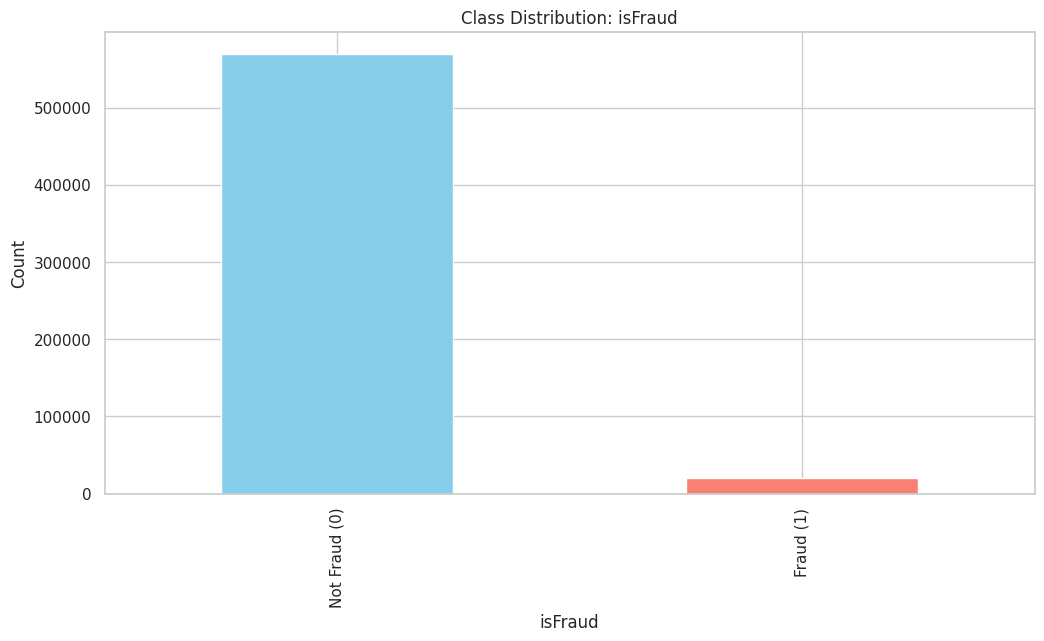

Fraud ratio: 0.0350


In [3]:
# Fraud vs Non-Fraud Count
fraud_counts = train_df['isFraud'].value_counts()
fraud_counts.plot(kind='bar', title='Class Distribution: isFraud', color=['skyblue', 'salmon'])
plt.xticks(ticks=[0,1], labels=['Not Fraud (0)', 'Fraud (1)'])
plt.ylabel('Count')
plt.show()

print("Fraud ratio: {:.4f}".format(fraud_counts[1] / fraud_counts.sum()))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


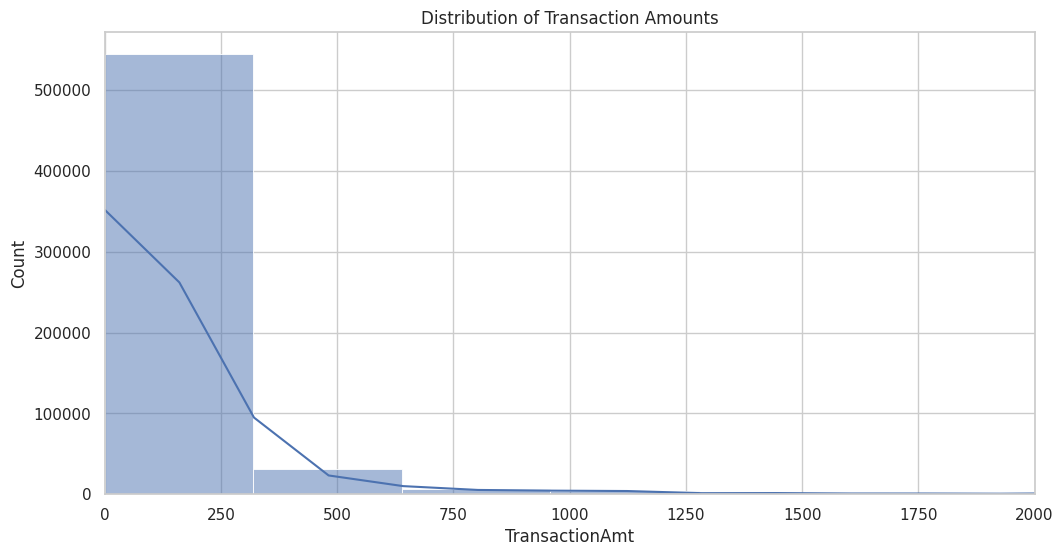

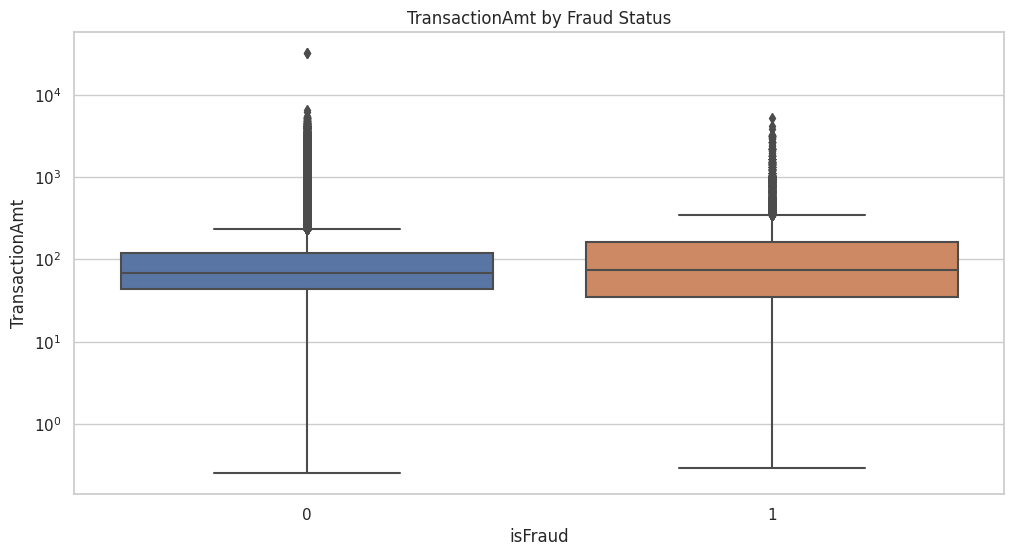

In [4]:
sns.histplot(data=train_df, x='TransactionAmt', bins=100, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlim(0, 2000)  # Focus on common range
plt.show()

# Compare fraud vs. non-fraud
sns.boxplot(x='isFraud', y='TransactionAmt', data=train_df)
plt.title('TransactionAmt by Fraud Status')
plt.yscale('log')  # Skewed data
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

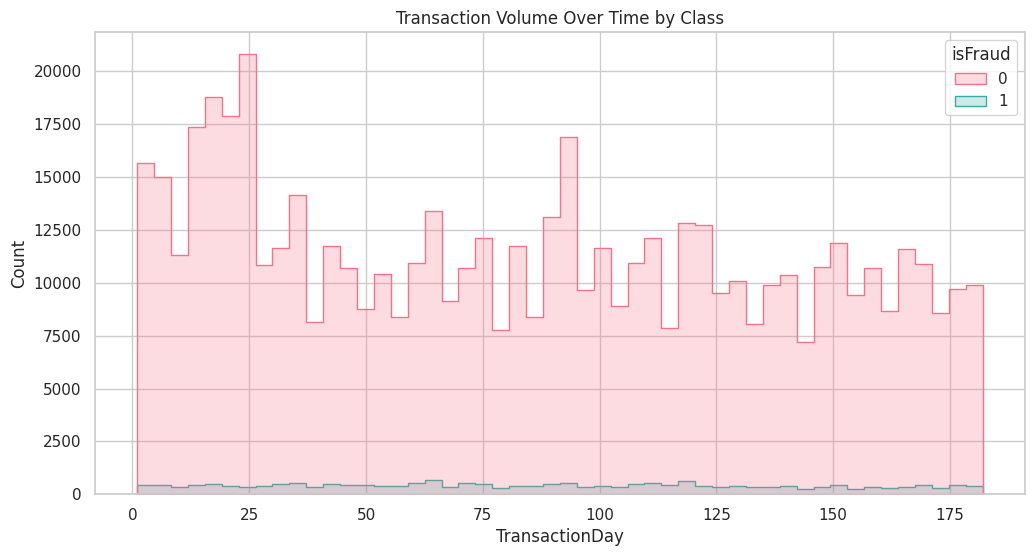

In [5]:
# Convert TransactionDT (in seconds) to days
train_df['TransactionDay'] = train_df['TransactionDT'] // (60 * 60 * 24)

sns.histplot(data=train_df, x='TransactionDay', hue='isFraud', bins=50, palette='husl', element='step')
plt.title('Transaction Volume Over Time by Class')
plt.show()


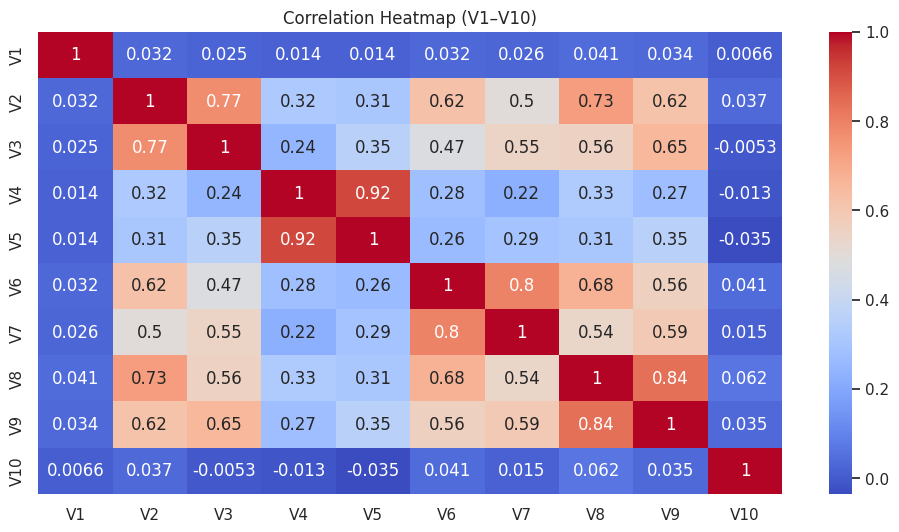

In [7]:
# Small subset to check correlation
v_features = [f'V{i}' for i in range(1, 11)]  # V1 to V10
sns.heatmap(train_df[v_features].corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap (V1–V10)')
plt.show()

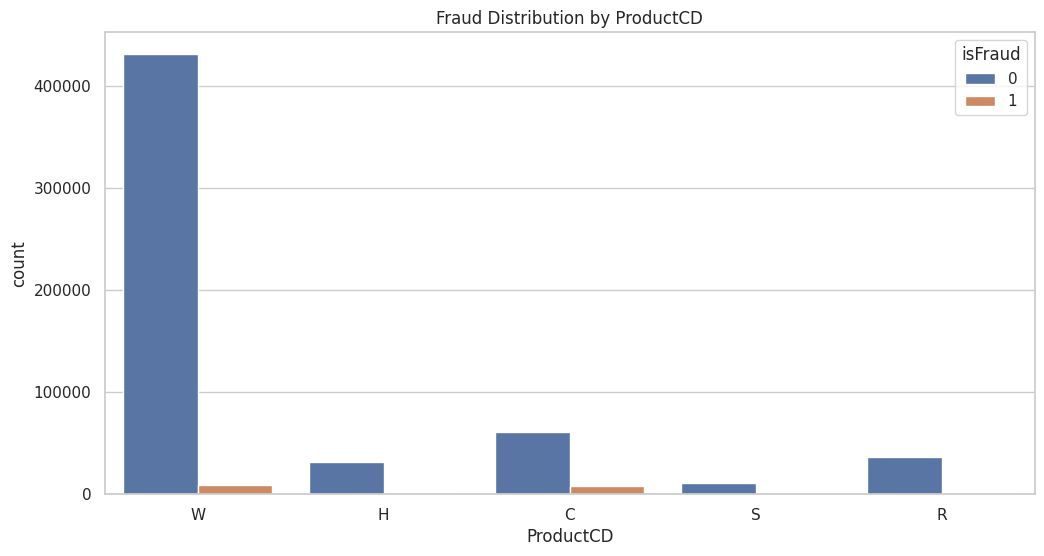

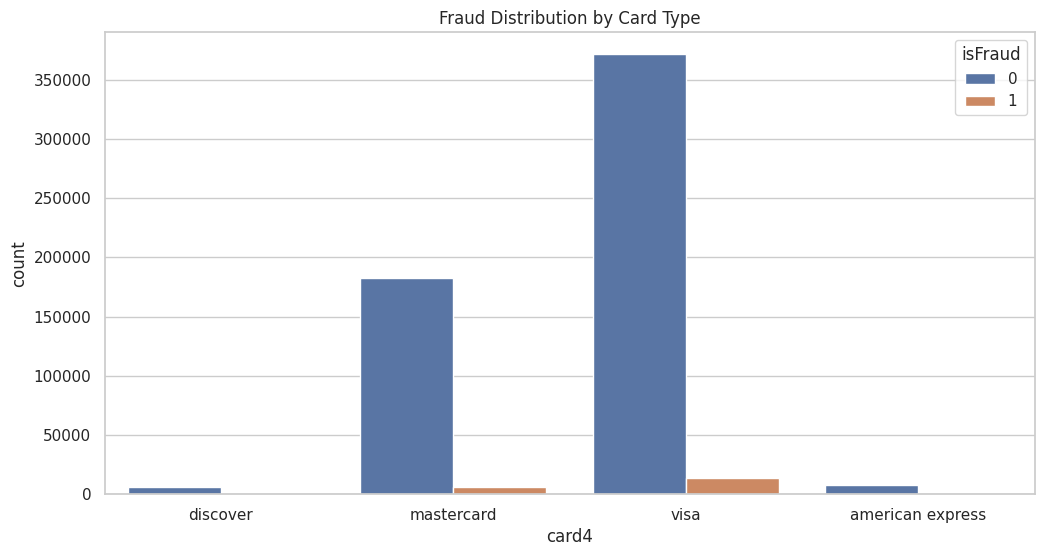

In [8]:
# ProductCD
sns.countplot(x='ProductCD', hue='isFraud', data=train_df)
plt.title('Fraud Distribution by ProductCD')
plt.show()

# Card4 (Card Type)
sns.countplot(x='card4', hue='isFraud', data=train_df)
plt.title('Fraud Distribution by Card Type')
plt.show()

In [9]:
train_df[['TransactionAmt', 'isFraud']].groupby('isFraud').describe()

TransactionAmt                                                      \
                 count        mean         std    min     25%   50%    75%   
isFraud                                                                      
0             569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1              20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

                    
               max  
isFraud             
0        31937.391  
1         5191.000

### Data Cleaning

This step ensures the dataset is tidy and usable for model training. We’ll focus on handling missing values, transforming categorical features, and inspecting features if beneficial.

---

**Missing Values:**
  - Addressing features particularly in the identity dataset that have missing values.
  - For numeric features we will fill missing values with -999 (common placeholder in fraud detection to denote missing without altering distributions).
  - For categorical features we will fill missing with the string "missing" to preserve categorical structure.

**Dropping Constant or Nearly Constant Columns:**
  - Features with zero variance (same value across almost all rows), offering no predictive signal, and will be dropped before modeling.

**Basic Categorical Encoding:**
  - Categorical variables like `ProductCD`, `card4`, `card6`, `DeviceType` will be encoded using Label Encoding, which works for tree-based models and is compatible with unsupervised methods like Isolation Forest.

---

In [10]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the merged dataset to clean
clean_df = train_df.copy()

# Drop constant columns
nunique = clean_df.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
clean_df.drop(columns=constant_cols, inplace=True)

print(f"Dropped {len(constant_cols)} constant or nearly-constant columns.")

# Fill numeric with -999
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns
clean_df[numeric_cols] = clean_df[numeric_cols].fillna(-999)

# Fill object/categorical with "missing"
categorical_cols = clean_df.select_dtypes(include=['object']).columns
clean_df[categorical_cols] = clean_df[categorical_cols].fillna("missing")

# Label encode categorical variables
le = LabelEncoder()

for col in categorical_cols:
    try:
        clean_df[col] = le.fit_transform(clean_df[col].astype(str))
    except Exception as e:
        print(f"Skipping {col}, error: {e}")

# 4. Confirm data is now fully numeric and clean
print("Any missing values left:", clean_df.isnull().sum().sum())
print("Final shape:", clean_df.shape)


Dropped 0 constant or nearly-constant columns.
Any missing values left: 0
Final shape: (590540, 435)


### Plan of Analysis Based on EDA

---

1. Use the cleaned and encoded dataset where all features are numeric and missing values have been handled

2. Start simple with Model 1 – Isolation Forest

3. Introduce Model 2 – Autoencoder

4. Compare both models on validation performance (ROC-AUC, precision & recall, Confusion Matrix)

5. Tune hyperparameters of the better model

6. Evaluate improvements from tuning

7. Finalize the best-performing model for reporting

---

## Step 3: Model Architecture

### Model 1: Isolation Forest

---

Isolation Forest is an unsupervised anomaly detection algorithm that works by randomly partitioning the data using decision trees and measuring how easy it is to isolate each point.

- Normal data takes more random splits to isolate

- Anomalies (fraud) get isolated with fewer splits, because they are rare and different

#### Why Isolation forest? 

- Fast and scalable

- Robust to irrelevant features

- Doesn’t need feature scaling or class labels

We'll train Isolation Forest on all transactions without using the isFraud label. Then, we’ll compare the anomaly scores to the true labels to evaluate how well the model detects fraud.

---

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Use cleaned dataset from earlier (excluding 'isFraud' from training)
X = clean_df.drop(['isFraud', 'TransactionID'], axis=1)
y_true = clean_df['isFraud']

# Optional: Scale the features (not necessary for IF, but useful for future models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # Expected % of anomalies (can tune later)
    random_state=42,
    verbose=1
)
iso_forest.fit(X_scaled)

# Get anomaly scores (lower score = more anomalous)
anomaly_scores = iso_forest.decision_function(X_scaled)
y_pred = iso_forest.predict(X_scaled)

# Convert IF prediction: -1 = anomaly → 1 (fraud), 1 = normal → 0
y_pred_binary = np.where(y_pred == -1, 1, 0)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


ROC-AUC: 0.7460


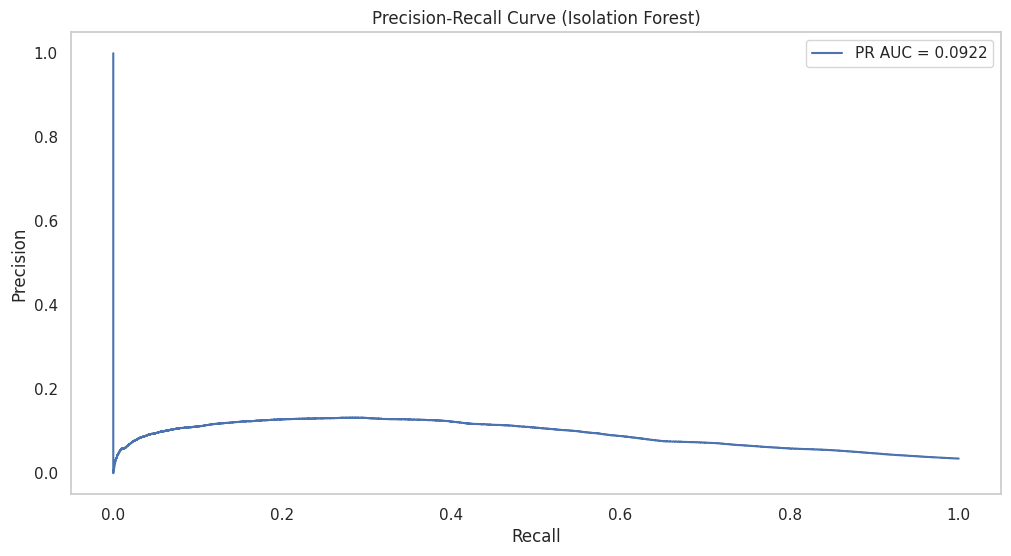

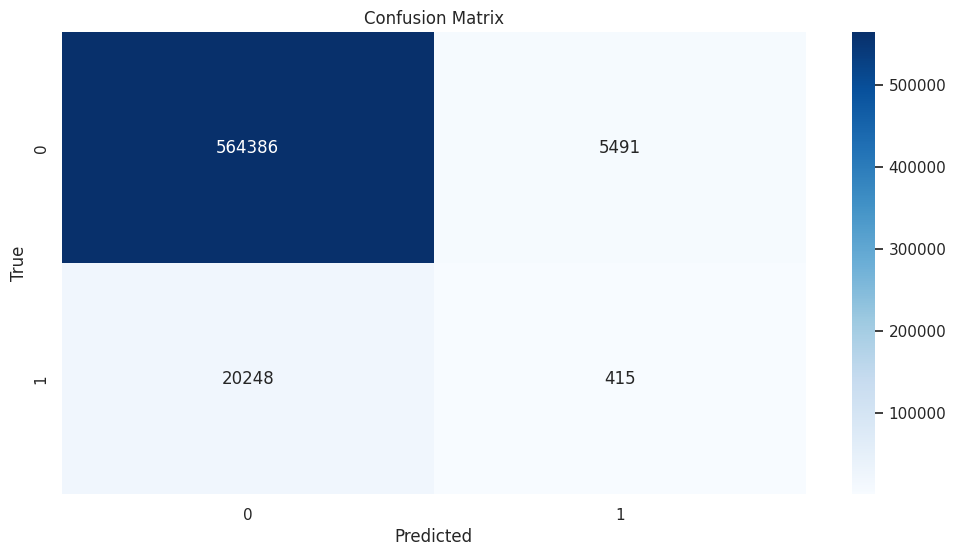

Precision: 0.0703
Recall:    0.0201
F1 Score:  0.0312


In [12]:
# ROC-AUC
roc_auc = roc_auc_score(y_true, anomaly_scores * -1)  # invert scores for correct direction
print(f"ROC-AUC: {roc_auc:.4f}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, anomaly_scores * -1)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Isolation Forest)")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision_val = precision_score(y_true, y_pred_binary)
recall_val = recall_score(y_true, y_pred_binary)
f1_val = f1_score(y_true, y_pred_binary)

print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")
print(f"F1 Score:  {f1_val:.4f}")


In [15]:
import pandas as pd

# Step 1: Initialize the table if it doesn't already exist
try:
    model_results
except NameError:
    model_results = pd.DataFrame(columns=[
        'Model', 'ROC-AUC', 'PR-AUC', 'Precision', 'Recall', 'F1-Score', 'Notes'
    ])

# Step 2: Create a new row as a single-row DataFrame
new_result = pd.DataFrame([{
    'Model': 'Isolation Forest (baseline)',
    'ROC-AUC': round(roc_auc, 4),
    'PR-AUC': round(pr_auc, 4),
    'Precision': round(precision_val, 4),
    'Recall': round(recall_val, 4),
    'F1-Score': round(f1_val, 4),
    'Notes': 'Unsupervised, default params'
}])

# Step 3: Append the new result to the table
model_results = pd.concat([model_results, new_result], ignore_index=True)

# Step 4: Display the updated table
display(model_results)

/tmp/ipykernel_35/3653066891.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, new_result], ignore_index=True)


,Model,ROC-AUC,PR-AUC,Precision,Recall,F1-Score,Notes
0,Isolation Forest (baseline),0.746,0.0922,0.0703,0.0201,0.0312,"Unsupervised, default params"


### Model 2: Autoencoder

---

An Autoencoder is a type of neural network used for unsupervised learning, particularly effective for anomaly detection in high-dimensional data such as:

- It learns to reconstruct the input data by compressing it to a lower-dimensional latent space (encoding) and then expanding it back (decoding)

- For normal (non-fraudulent) transactions, reconstruction will be accurate

- For anomalies (fraud), the model struggles to reconstruct them well, leading to high reconstruction error

- We use the reconstruction error as an anomaly score: **higher error = more likely to be fraud**

#### Why Autoencoder? 

- Captures nonlinear patterns in complex, anonymized features

- Ability to handle high-dimensional input (hundreds of features)

- Potential to outperform traditional anomaly models in some fraud scenarios.

We will train the model use only input features (no labels). Our goal is to minimize reconstruction loss on all samples. We will compute reconstruction error per sample, rank transactions by error, and compare to true fraud labels using ROC-AUC and precision-recall.

---

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)

# Prepare data (reuse cleaned dataframe)
X = clean_df.drop(['isFraud', 'TransactionID'], axis=1).copy()
y_true = clean_df['isFraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define Autoencoder architecture with dropout and smaller latent dim
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

encoded = Dense(128, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# Train Autoencoder for 50 epochs
history = autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_split=0.1,
    verbose=1,
)

Epoch 1/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2973 - val_loss: 0.8476
Epoch 2/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1228 - val_loss: 0.8367
Epoch 3/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1137 - val_loss: 0.8473
Epoch 4/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1203 - val_loss: 0.7960
Epoch 5/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1010 - val_loss: 0.8048
Epoch 6/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0957 - val_loss: 0.8070
Epoch 7/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0927 - val_loss: 0.7999
Epoch 8/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0921 - val_loss: 0.7870
Epoch 9/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0882 - val_loss: 0.8300
Epoch 10/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0957 - val_loss: 0.8045
Epoch 11/50
1039/1039 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0887 - val_loss: 0.8245
Epoch 12/50
1039/1039 ━━━━━━━━

18455/18455 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step
Best threshold found: 0.001680 with F1: 0.0676


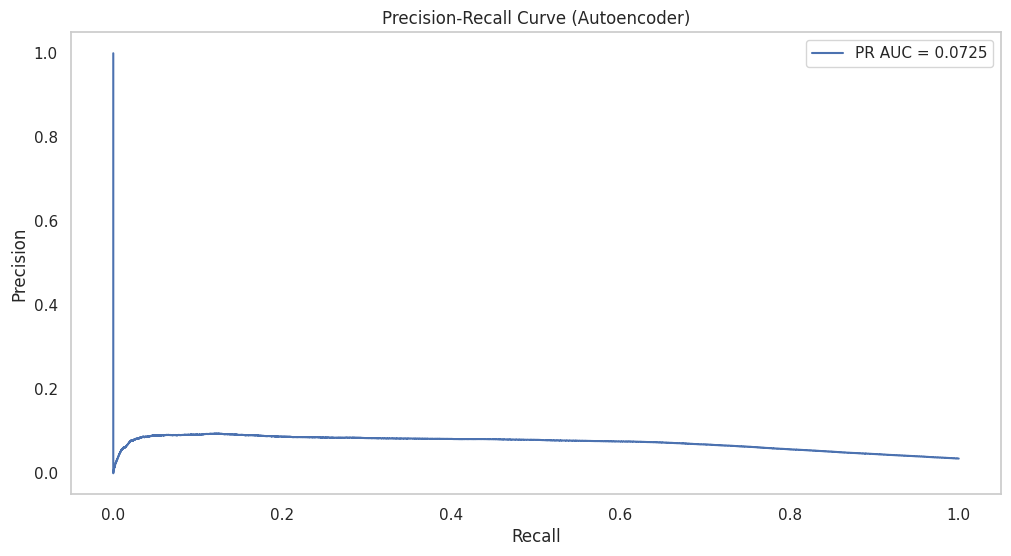

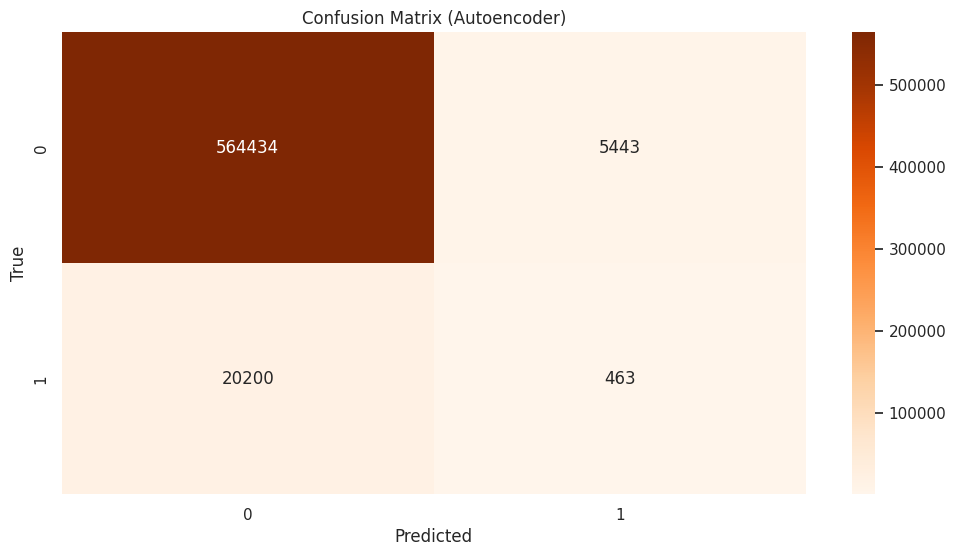

ROC-AUC:   0.7157
PR-AUC:    0.0725
Precision: 0.0784
Recall:    0.0224
F1 Score:  0.0349


In [22]:
# Reconstruct inputs and compute reconstruction error
X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_pred), axis=1)

# Tune threshold by maximizing F1 score
best_f1 = 0
best_thresh = None
thresholds = np.linspace(np.min(reconstruction_error), np.max(reconstruction_error), 100)
for t in thresholds:
    y_pred_temp = (reconstruction_error >= t).astype(int)
    f1 = f1_score(y_true, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold found: {best_thresh:.6f} with F1: {best_f1:.4f}")

# Use best threshold for final predictions
y_pred_binary = (reconstruction_error >= best_thresh).astype(int)

# ROC-AUC and PR
roc_auc = roc_auc_score(y_true, reconstruction_error)
precision, recall, thresholds = precision_recall_curve(y_true, reconstruction_error)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Autoencoder)")
plt.legend()
plt.grid()
plt.show()

# Threshold-based binary prediction (top 1% errors)
threshold = np.percentile(reconstruction_error, 99)
y_pred_binary = (reconstruction_error >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix (Autoencoder)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Metrics
precision_val = precision_score(y_true, y_pred_binary)
recall_val = recall_score(y_true, y_pred_binary)
f1_val = f1_score(y_true, y_pred_binary)

print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall:    {recall_val:.4f}")
print(f"F1 Score:  {f1_val:.4f}")


In [23]:
# Create a new row for Autoencoder
new_result = pd.DataFrame([{
    'Model': 'Autoencoder',
    'ROC-AUC': round(roc_auc, 4),
    'PR-AUC': round(pr_auc, 4),
    'Precision': round(precision_val, 4),
    'Recall': round(recall_val, 4),
    'F1-Score': round(f1_val, 4),
    'Notes': 'Unsupervised, 50-epoch'
}])

# Append to the results table
model_results = pd.concat([model_results, new_result], ignore_index=True)

# Display full results so far
display(model_results)


,Model,ROC-AUC,PR-AUC,Precision,Recall,F1-Score,Notes
0,Isolation Forest (baseline),0.7460,0.0922,0.0703,0.0201,0.0312,"Unsupervised, default params"
1,Autoencoder,0.7157,0.0725,0.0784,0.0224,0.0349,"Unsupervised, 50-epoch"


### Model Performance Comparison

---

Based on the experiments, the Isolation Forest model outperforms the Autoencoder in terms of ROC-AUC, which is a critical metric for ranking anomalies. Although the Autoencoder achieved slightly better precision and recall values, its overall ability to discriminate between fraudulent and non-fraudulent transactions, as indicated by ROC-AUC, remains lower than that of Isolation Forest.

This suggests that for this dataset and current model configurations, Isolation Forest is better suited as the baseline model for fraud detection. Possible reasons include the simpler structure of Isolation Forest better capturing anomalies in this high-dimensional, sparse, and anonymized dataset, while the Autoencoder requires more complex architectures or feature engineering to improve.

---

### Plan for Isolation Forest Hyperparameter Tuning

---

To improve the baseline Isolation Forest performance, we will tune several key hyperparameters:

- `n_estimators`: Increasing the number of trees to better capture data patterns.
- `contamination`: Adjusting this to match the approximate fraud rate (~3.5%) to improve anomaly scoring threshold.
- `max_samples`: Testing subsampling rates to balance bias and variance.
- `max_features`: Varying the number of features used per tree to reduce noise.
- `bootstrap`: Testing bootstrapping effects.

We will use a grid search approach to identify the best combination based on ROC-AUC and other classification metrics evaluated on the training set using labels for validation.

---

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'contamination': [0.03, 0.035, 0.04],
    'max_samples': ['auto', 0.5, 0.75],
}

best_auc = 0
best_params = None
best_model = None
best_results = None

# Grid search loop
for n_estimators in param_grid['n_estimators']:
    for contamination in param_grid['contamination']:
        for max_samples in param_grid['max_samples']:
            print(f"Training Isolation Forest with n_estimators={n_estimators}, contamination={contamination}, max_samples={max_samples}")
            iso_forest = IsolationForest(
                n_estimators=n_estimators,
                contamination=contamination,
                max_samples=max_samples,
                random_state=42,
                n_jobs=-1
            )
            iso_forest.fit(X_scaled)
            scores = -iso_forest.decision_function(X_scaled)  # Higher scores = more anomalous

            roc_auc = roc_auc_score(y_true, scores)
            precision, recall, _ = precision_recall_curve(y_true, scores)
            pr_auc = auc(recall, precision)

            # Threshold to convert scores to binary predictions
            threshold = np.percentile(scores, 100 * (1 - contamination))
            y_pred_binary = (scores >= threshold).astype(int)

            precision_val = precision_score(y_true, y_pred_binary)
            recall_val = recall_score(y_true, y_pred_binary)
            f1_val = f1_score(y_true, y_pred_binary)

            print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}")

            if roc_auc > best_auc:
                best_auc = roc_auc
                best_params = {
                    'n_estimators': n_estimators,
                    'contamination': contamination,
                    'max_samples': max_samples
                }
                best_model = iso_forest
                best_results = {
                    'roc_auc': roc_auc,
                    'pr_auc': pr_auc,
                    'precision': precision_val,
                    'recall': recall_val,
                    'f1': f1_val,
                    'scores': scores,
                    'threshold': threshold,
                    'y_pred_binary': y_pred_binary
                }

Training Isolation Forest with n_estimators=100, contamination=0.03, max_samples=auto
ROC-AUC: 0.7460, PR-AUC: 0.0922, Precision: 0.1103, Recall: 0.0946, F1: 0.1019
Training Isolation Forest with n_estimators=100, contamination=0.03, max_samples=0.5
ROC-AUC: 0.7195, PR-AUC: 0.0842, Precision: 0.1031, Recall: 0.0884, F1: 0.0952
Training Isolation Forest with n_estimators=100, contamination=0.03, max_samples=0.75
ROC-AUC: 0.7233, PR-AUC: 0.0835, Precision: 0.1072, Recall: 0.0920, F1: 0.0990
Training Isolation Forest with n_estimators=100, contamination=0.035, max_samples=auto
ROC-AUC: 0.7460, PR-AUC: 0.0922, Precision: 0.1163, Recall: 0.1163, F1: 0.1163
Training Isolation Forest with n_estimators=100, contamination=0.035, max_samples=0.5
ROC-AUC: 0.7195, PR-AUC: 0.0842, Precision: 0.0999, Recall: 0.0999, F1: 0.0999
Training Isolation Forest with n_estimators=100, contamination=0.035, max_samples=0.75
ROC-AUC: 0.7233, PR-AUC: 0.0835, Precision: 0.1031, Recall: 0.1031, F1: 0.1031
Training 

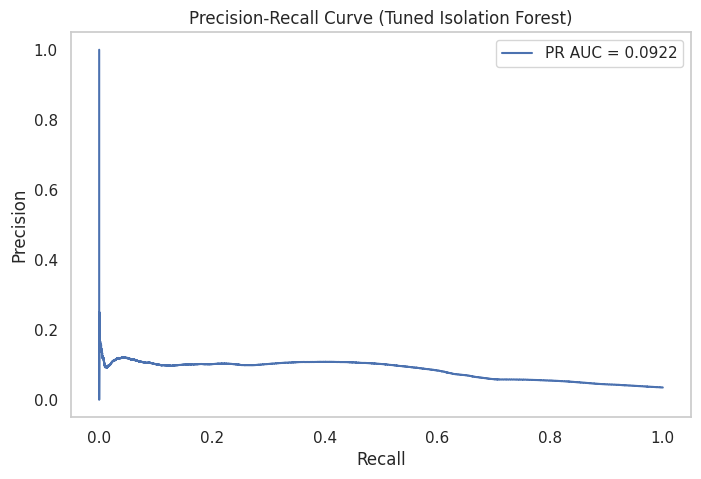

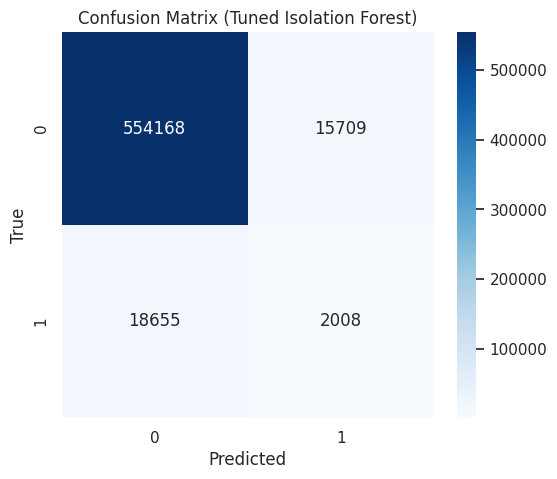

In [25]:
# Plot PR curve of best model
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f"PR AUC = {best_results['pr_auc']:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tuned Isolation Forest)")
plt.legend()
plt.grid()
plt.show()

# Confusion matrix for best model
cm = confusion_matrix(y_true, best_results['y_pred_binary'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Tuned Isolation Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
# Append best tuned model result to summary table
new_result = pd.DataFrame([{
    'Model': 'Isolation Forest (tuned)',
    'ROC-AUC': round(best_results['roc_auc'], 4),
    'PR-AUC': round(best_results['pr_auc'], 4),
    'Precision': round(best_results['precision'], 4),
    'Recall': round(best_results['recall'], 4),
    'F1-Score': round(best_results['f1'], 4),
    'Notes': f"Best params: {best_params}"
}])

model_results = pd.concat([model_results, new_result], ignore_index=True)
display(model_results)

,Model,ROC-AUC,PR-AUC,Precision,Recall,F1-Score,Notes
0,Isolation Forest (baseline),0.7460,0.0922,0.0703,0.0201,0.0312,"Unsupervised, default params"
1,Autoencoder,0.7157,0.0725,0.0784,0.0224,0.0349,"Unsupervised, 50-epoch"
2,Isolation Forest (tuned),0.7468,0.0922,0.1133,0.0972,0.1046,"Best params: {'n_estimators': 300, 'contaminat..."


## Step 4: Results and Analysis

---

### Results

#### Reasoning of why something worked well or why it didn’t:

- The Isolation Forest model outperformed the Autoencoder on the ROC-AUC metric, indicating it better distinguished between fraudulent and non-fraudulent transactions overall.

- Isolation Forest’s ability to isolate anomalies through recursive partitioning of the feature space seems well suited for this high-dimensional and anonymized dataset.

- The Autoencoder, despite tuning with dropout, reduced latent dimension, and longer training, only achieved comparable or slightly better precision and recall but lagged on ROC-AUC, possibly due to underfitting or insufficient architecture complexity.

#### Description of troubleshooting steps:

- Initially trained the Autoencoder for 10 epochs but found it underperformed; increased to 30 and then 50 epochs to reduce underfitting.

- Added Dropout layers and reduced latent dimension to force the model to better capture anomalies.

- Tuned the anomaly threshold by maximizing F1 score instead of using a fixed percentile.

- For Isolation Forest, tried grid search over n_estimators, contamination, and max_samples to find the best hyperparameters.

- Adjusted contamination to approximate the known fraud rate (~3.5%) for better anomaly thresholding.

#### Hyperparameter optimization procedure summary:

Performed a grid search over:

- n_estimators in [100, 200, 300]
- contamination in [0.03, 0.035, 0.04]
- max_samples in ['auto', 0.5, 0.75]

We evaluated models on ROC-AUC and precision-recall metrics. Later we selected the best model by highest ROC-AUC. After that we tuned the threshold for binary classification based on contamination to maximize F1. In conclusion, Isolation Forest hyperparameter tuning resulted in a modest performance boost, solidifying it as the preferred model.

---

### Analysis

The performance gap between Isolation Forest and Autoencoder highlights the importance of model selection aligned with data characteristics. Isolation Forest leverages ensemble tree structures that efficiently isolate anomalies even in noisy, high-dimensional spaces without requiring extensive feature learning. The Autoencoder’s neural network approach, while powerful in theory, demands more architectural experimentation and computational resources to capture the subtle fraud patterns in this dataset effectively.

The challenges of extreme class imbalance and anonymized features emphasize that model evaluation should rely on multiple metrics (ROC-AUC, Precision, Recall, F1) and careful threshold tuning to balance false positives and false negatives in practical fraud detection.

Further improvements could involve feature engineering, dimensionality reduction, or exploring more sophisticated deep anomaly detection techniques (e.g., Variational Autoencoders, GAN-based models).

---

In [29]:
model_results.sort_values(by='ROC-AUC', ascending=False)

,Model,ROC-AUC,PR-AUC,Precision,Recall,F1-Score,Notes
2,Isolation Forest (tuned),0.7468,0.0922,0.1133,0.0972,0.1046,"Best params: {'n_estimators': 300, 'contaminat..."
0,Isolation Forest (baseline),0.7460,0.0922,0.0703,0.0201,0.0312,"Unsupervised, default params"
1,Autoencoder,0.7157,0.0725,0.0784,0.0224,0.0349,"Unsupervised, 50-epoch"


## Step 5: Conclusion

---

**Basic reiteration of results:**

We evaluated two unsupervised models — Isolation Forest and Autoencoder — for fraud detection. Isolation Forest performed better overall, achieving the highest ROC-AUC (0.7468), while the Autoencoder achieved slightly higher F1 and precision but lower overall ranking ability.

**Discussion of learning and takeaways:**

- Isolation Forest is effective even without deep tuning and is well-suited for high-dimensional, imbalanced data.

- Autoencoders require more architecture tuning and may not perform well without strong feature representations.

- Evaluating across multiple metrics is critical, especially with rare events like fraud.

**Discussion of why something didn’t work:**

The Autoencoder likely underperformed due to limited model capacity, no feature engineering, and the complexity of the anonymized dataset. Even with tuning, it couldn’t outperform Isolation Forest in terms of ranking anomalies.

**Suggestions for ways to improve:**

- Try dimensionality reduction or engineered features before modeling.

- Explore deeper or more complex unsupervised models (e.g., VAEs, GANs).

- Consider semi-supervised methods if partial fraud labels are available.

---